## Importing Packages

In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor, ExactGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# from utilities.fits import fit
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
# from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
from gpytorch.metrics import mean_standardized_log_loss, negative_log_predictive_density,  mean_squared_error
import time
import numpy as np
# from utilities import plot,fits,gmm,errors,predict,preprocess

#### Latexifying Figures

In [28]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Figures/"

## Data

In [5]:
def dataset_load(appliances, train, test=None, bias = False):
    x_train = []
    y_train = []
    train_time = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    app = 0

    ### train
    torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
            

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values

        timetrain = df["Timestamp"]
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))
        train_time.extend(timetrain)

    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    ## test
    x_test = []
    test_time = []
    y_test = []
    x_test_timestamp = []
    app = 0
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
           
        timetest = df["Timestamp"]
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        
        if bias==True:
            x = x + 100*np.ones(x.shape[0])
        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)
        test_time.extend(timetest)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).to(torch.float32)
    y_train = torch.tensor(y_train).reshape(-1,).to(torch.float32)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).to(torch.float32)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).to(torch.float32)
    y_test = torch.tensor(y_test).reshape(-1,).to(torch.float32)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float32)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, test_time, train_time


In [6]:
train ={
    
    1:{
                    'start_time': "2011-04-28" ,
                    'end_time': "2011-05-15"
                },
        3: {
                'start_time': "2011-04-19" ,
                'end_time': "2011-05-22"
            }
                }
test = { 2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }

appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [7]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, test_time, train_time = dataset_load(appliances, train, test, bias=False)

/tmp/ipykernel_3906605/3127361735.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,).to(torch.float32)


In [8]:
x_train.shape, x_train_timestamp.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([24918, 1]),
 torch.Size([24918, 1]),
 torch.Size([15656, 1]),
 torch.Size([24918]),
 torch.Size([15656]))

In [9]:
x_train_full = x_train
y_train = y_train
x_test_full = x_test
x_train_full.shape, x_test_full.dtype

(torch.Size([24918, 1]), torch.float32)

## GP Model

In [10]:
def GP_model(train, test):
        if (train):
                kernel1 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=1, active_dims=(0)))
                kernel = kernel1
                inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],20)]
                model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                                inducing_points).to("cuda")

                loss = model.fit(lr=1e-3, n_epochs=3000,verbose=1,thetas=None,
                        random_state=0)
                plt.plot(np.asarray(loss[0]))  

                ## Save model
                model_name = "Point_to_point_main_power.pt"
                torch.save(model.state_dict(), os.path.join(
                "Neurips/models", model_name))
        if (test):
                kernel1 = ScaleKernel(MaternKernel(nu=2.5))
                kernel = kernel1
                inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],20)] 
                model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                                inducing_points).to("cuda")
                model_name = "Point_to_point_main_power.pt"
                model.load_state_dict(torch.load(
                os.path.join("./models", model_name)))
        return model

In [11]:
model = GP_model(train=False, test=True)

## Figure 2(b)

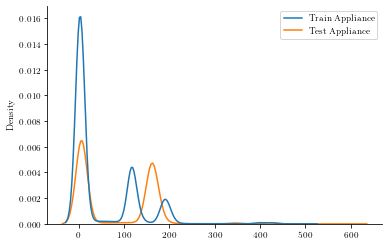

In [12]:
plt.figure()
latexify(width_scale_factor=2.5, fig_height=1.75)
sns.kdeplot(data = {"Train Appliance": scaler_y.inverse_transform(y_train.reshape(-1,1).cpu()).squeeze(),"Test Appliance": (y_test.cpu()).squeeze() })
sns.despine()
# savefig("kde")

## Figure 2(a)

In [13]:
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656) #+ 100*np.ones(np.array(x_test).shape[0])
x_time = np.linspace(scaler_time.inverse_transform(x_test_timestamp).min(), scaler_time.inverse_transform(x_test_timestamp).max(), 15656)
x_lin_scale = scaler_x.transform(x_lin.reshape(-1,1)).flatten() 
x_new =torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32)

x_new.shape, x_new.dtype

(torch.Size([15656, 1]), torch.float32)

In [14]:
pred_dist = model.predict(x_new.to("cuda"))
y_mean = pred_dist.loc 
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1))

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


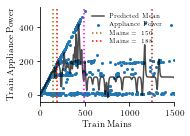

In [15]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.5)
start = 500
idx = 4000
plt.plot(x_lin, y_mean, 'k', label=" Predicted Mean", alpha=0.7)
plt.scatter( scaler_x.inverse_transform(x_train_full[:,0].reshape(-1,1)), scaler_y.inverse_transform(y_train.reshape(-1,1)), s = 4, label= "Appliance Power")
plt.xlim(00,1500)
sns.despine()
# plt.title("Train Mains Vs Train Applaince along with Predicted Means")

plt.xlabel("Train Mains")
plt.ylabel("Train Appliance Power")
# plt.show()
plt.axvline(x=145,color='olive', linestyle='dotted',label = "Mains = ~150")
plt.axvline(x=188,color='red', linestyle='dotted',label = "Mains = ~188")

plt.axvline(x=490,color='magenta', linestyle='dotted')
# # plt.axvline(x=430,color='red', linestyle='dotted',label = "Mains = ~188")
plt.axvline(x=1250,color='brown', linestyle='dotted')

plt.legend( frameon = False, fontsize = 6, bbox_to_anchor=(0.35, 0.55))
# savefig("Main_vs_app_mean")


## Figure 2(c)

In [16]:
values = test_time

x_ticks_labels = pd.to_datetime(values)
x_ticks_labels
time_ = [(i.split('-04:00')[0].strip()) for i in test_time[:]]

date = [(i.split(' ')[0].strip()) for i in time_[:]]
mins_data = [(i.split(' ')[1].strip()) for i in time_[:]]
secs = [(i.split(':00')[1].strip()) for i in time_[:]]
def date_con(input_string:str):
  year,month,day = input_string.split("-")
  ret_month = ''
  if(int(month)==4):
    ret_month = 'April'
  elif(int(month)==5):
    ret_month  = 'May'
  
  ret_string  = f"{day} {ret_month}"
  return ret_string

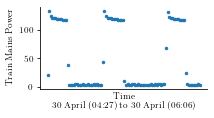

In [17]:

idx = 100
fig, ax = plt.subplots(1,1) 
start = 13100
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
latexify(width_scale_factor=3, fig_height=1.75)
ax.scatter(time_plot[start : start + idx], scaler_x.inverse_transform(x_train)[start : start + idx], label = "Train Main", s = 6)
mins = mins_data[start : start + idx]
dates = date[start : start + idx]
ax.set_ylabel("Train Mains Power" )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
)
ax.set_xlabel("Time" + "\n" + date_con(dates[0]) +" (" + mins[0][:-3]+ ") " + "to  " + date_con(dates[-1])+ " (" + mins[-1][:-3]+ ")")
sns.despine()
# plt.show()
# savefig("Train_Scatter")

## Prediction

In [12]:
pred_dist = model.predict((x_test_full).to("cuda"))
y_mean = pred_dist.loc 
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1).cpu()).squeeze()

print(y_test.shape, y_mean.shape)
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

torch.Size([15656]) (15656,)


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


## MAE

In [13]:
mae = torch.abs(torch.tensor(y_mean) - y_test).mean(dim=-1)
mae

tensor(18.4366)

## MSLL

In [17]:
from math import pi
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# msll = mean_standardized_log_loss(torch.ensor(y_mean), y_test)
f_var= torch.tensor(var_pred)
f_mean = torch.tensor(y_mean)
msll = 0.5 * (torch.log(2 * pi * f_var) + torch.square(y_test - f_mean) / (2 * f_var)).mean(dim=-1)
msll

tensor(9.4116)

## NLPD

In [21]:
# import math
# def log_prob(y_pred, value):
#         r"""
#         See :py:meth:`torch.distributions.Distribution.log_prob
#         <torch.distributions.distribution.Distribution.log_prob>`.
#         """


#         mean, covar = y_pred.loc.cpu(), y_pred.variance.cpu()
#         diff = value - mean

#         # Repeat the covar to match the batch shape of diff
#         # if diff.shape[:-1] != covar.batch_shape:
#         #     if len(diff.shape[:-1]) < len(covar.batch_shape):
#         #         diff = diff.expand(covar.shape[:-1])
#         #     else:
#         #         padded_batch_shape = (*(1 for _ in range(diff.dim() + 1 - covar.dim())), *covar.batch_shape)
#         #         covar = covar.repeat(
#         #             *(diff_size // covar_size for diff_size, covar_size in zip(diff.shape[:-1], padded_batch_shape)),
#         #             1,
#         #             1,
#         #         )

#         # Get log determininant and first part of quadratic form
#         covar = covar.evaluate_kernel()
#         inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=diff.unsqueeze(-1), logdet=True)

#         res = -0.5 * sum([inv_quad, logdet, diff.size(-1) * math.log(2 * math.pi)])
#         return res

In [22]:
# var_pred = pred_dist.variance
# var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# # msll = mean_standardized_log_loss(torch.ensor(y_mean), y_test)
# f_var= torch.tensor(var_pred)
# f_mean = torch.tensor(y_mean)
# nlpd = -pred_dist.log_prob(y_test) / y_test.shape[-1]

## QCE 95

In [23]:
quantile = 95.0
standard_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
deviation = standard_normal.icdf(torch.as_tensor(0.5 + 0.5 * (quantile / 100)))
std_pred = pred_dist.stddev
std_pred = torch.tensor(scaler_y.inverse_transform(std_pred.reshape(-1,1).detach().cpu()).squeeze())
lower = torch.tensor(y_mean) - deviation * std_pred 
upper = torch.tensor(y_mean) + deviation * std_pred 
n_samples_within_bounds = ((y_test > lower) * (y_test < upper)).sum(-1)
fraction = n_samples_within_bounds / y_test.shape[-1]
qce = torch.abs(fraction - quantile / 100)
qce

tensor(0.0360)

## Var plot

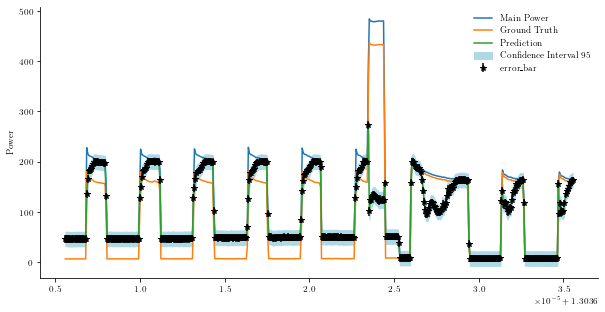

In [24]:
idx = 500
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
start = 4000
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
latexify(width_scale_factor=2, fig_height=1.75)
ax.plot(time_plot[start : start + idx], scaler_x.inverse_transform(x_test_full.cpu().reshape(-1,1))[start : start + idx], label = "Main Power")
ax.plot(time_plot[start : start + idx], y_test.cpu()[start : start + idx], label = "Ground Truth")
ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
ax.fill_between(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
# ax.errorbar(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten(), yerr=np.sqrt(var_pred[start : start + idx]).flatten(), fmt='k*', label = "error_bar")
plt.legend(frameon=False)
ax.set_ylabel("Power" )
sns.despine()
# plt.show()


## Figure 1 Plots (4800:200, 13000:300, 4000:500)

saving image to ./Figures/Point_to_point_plt2_latexified.pdf
Figure size: [3.   1.75]


<Figure size 216x126 with 0 Axes>

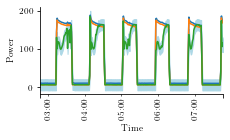

In [47]:
idx = 300 #x2.shape[0]
start = 13000

plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("./time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] = scaler_x.inverse_transform(x_test_full.cpu().reshape(-1,1) )
df["Ground Truth"] = y_test.cpu()
df["Prediction"] = y_mean
df[start:start+idx].plot(rot=90, legend=False)
plt.fill_between(df.index[start : start + idx], y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
# plt.errorbar(df.index[start : start + idx], y_mean[start : start + idx].flatten(), yerr=np.sqrt(var_pred[start : start + idx]).flatten(), fmt='k*', label = "error_bar")
sns.despine()
# df.plot.( rotation=90)
# plt.legend(frameon=False, bbox_to_anchor=(0.5, 0.5))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")
savefig("Point_to_point_plt2")

### Model Parameters

In [26]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-2.4230], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.7693], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-1.6767, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[-3.0339]], device='cuda:0', requires_grad=True)
mll.model.covar_module.inducing_points Parameter containing:
tensor([[-0.2423],
        [-0.4043],
        [-0.4716],
        ...,
        [ 0.4216],
        [-0.5382],
        [ 0.3627]], device='cuda:0', dtype=torch.float32, requires_grad=True)


## Calibration Plot

In [27]:
# from utilities import plot

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import jax.numpy as jnp
from sklearn.metrics import brier_score_loss
from probml_utils import is_latexify_enabled


def calibration_regression(mean, sigma, Y,label, color, ax=None):
    """
    mean : (n_samples,1) or (n_sample,) prediction mean 
    sigma : (n_samples,1) or (n_sample,) prediction sigma 
    Y : (n_samples,1) or (n_sample,) Y co-ordinate of ground truth 
    label :  string, 
    
    
    """

    marker_size = 6 if is_latexify_enabled else None
    if ax is None:
        fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = jnp.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")
    sns.despine()
    return df, df2

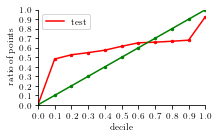

In [28]:
fig, ax = plt.subplots(1)
sigma_pred = jnp.sqrt(var_pred)
df, df1 = calibration_regression(y_mean.squeeze(), sigma_pred.squeeze(), 
                                     y_test.squeeze(), "test", "r", ax)
ax.legend()

In [29]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp

def ace(ideal,predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(ideal,predicted))
    
def mass_to_std_factor(mass=0.95):
    rv = norm(0.0, 1.0)
    std_factor = rv.ppf((1.0 + mass) / 2)
    return std_factor

def plot_find_p(y,mean_prediction, std_prediction, mass=0.95):
    std_factor = mass_to_std_factor(mass)
    idx = np.where(
        (y < mean_prediction + std_factor * std_prediction)
        & (y > mean_prediction - std_factor * std_prediction)
    )[0]

    p_hat = len(idx) / len(y)
    return (mass, p_hat)

def find_p_hat(y, mean_prediction,std_prediction):
    out = {}
    for mass in np.linspace(1e-10, 1-1e-20, 1000):
        out[mass] = plot_find_p(y, mean_prediction,std_prediction, mass)[1]
    df = pd.Series(out).to_frame()
    df.index.name = 'p'
    df.columns = ['p_hat']

    return df

In [30]:
cal= find_p_hat(np.array(y_test),y_mean,sigma_pred)
p=cal.index

In [31]:
# p.values,series_train.values
mae = ace(p.values, cal.values)
mae

DeviceArray(0.19643526, dtype=float32)

In [33]:
def ce(ideal,predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y,yhat):
      return jnp.abs(y-yhat)
    return (jax.vmap(rmse_loss,in_axes=(0,0))(ideal,predicted))

In [53]:
cerror = ce(p.values, cal.values)
cerrror = jnp.array(cerror.reshape(-1,))


(DeviceArray(0.3878203, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0.11173262, dtype=float32),
 DeviceArray(0.19643526, dtype=float32))

Text(0, 0.5, 'ECE')

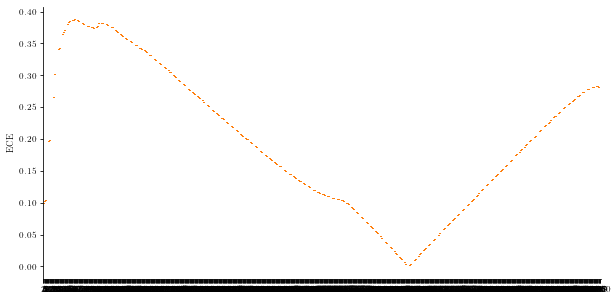

In [61]:
fig, ax = plt.subplots(1, figsize = (10,5))
data = np.array((cerror.std(), cerror.mean(),cerror.max(), cerror.min()))
ax.boxplot(cerror, 0, '')
sns.despine()
# ax.set_xticks(jnp.arange(1,4),labels=["Fridge"])
ax.set_ylabel("ECE")
# savefig("box_plot")